# Subject 001 - Analysis

### Load data


In [1]:
import sys
sys.path.append("..")

import mne
from mne_bids import BIDSPath, read_raw_bids
from src.utils import load_subject, pipeline
import numpy as np
from matplotlib import pyplot as plt

# DEBUG
PLOT_DATA = False

# Set subject
target_root = '../data'
target_subject = '001'
target_task = 'jacobsen'
target_suffix = 'eeg'

# Set BIDS path
target_path = BIDSPath(
    root = target_root, 
    subject = target_subject, 
    task = target_task, 
    suffix = target_suffix)

# Load Data
raw = load_subject(target_path)

# Plot RAW data
if PLOT_DATA: raw.plot();

raw


Extracting EDF parameters from /Users/saponaro/Developer/uni/eeg_penguin/data/sub-001/eeg/sub-001_task-jacobsen_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ../data/sub-001/eeg/sub-001_task-jacobsen_events.tsv.
Reading channel info from ../data/sub-001/eeg/sub-001_task-jacobsen_channels.tsv.
Reading electrode coords from ../data/sub-001/eeg/sub-001_task-jacobsen_electrodes.tsv.
Reading 0 ... 531967  =      0.000 ...  1038.998 secs...


/Users/saponaro/Developer/uni/eeg_penguin/notebooks/../src/utils.py:6: RuntimeWarning: The number of channels in the channels.tsv sidecar file (72) does not match the number of channels in the raw data file (73). Will not try to set channel names.
  raw = read_raw_bids(bids_path = given_path)
/Users/saponaro/Developer/uni/eeg_penguin/notebooks/../src/utils.py:6: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: 'AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'Iz', 'O1', 'O2', 'Oz', 'P1', 'P10', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP7', 'TP8'
  raw = read_raw_bids(bids_path = given_path)
/User

Measurement date,"June 10, 2011 10:39:12 GMT"
Experimenter,Unknown
Participant,sub-001
Digitized points,67 points
Good channels,"64 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


## Pipeline

Describe the pipeline

In [2]:
# EEG trace re-referenced to scalp average
raw = raw.set_eeg_reference(ref_channels = "average")
if PLOT_DATA: raw.plot();

# Set low/high-pass filters (l_freq = high-pass / h_freq = low-pass)
raw = raw.filter(l_freq = 1, h_freq = 25, fir_design = 'firwin')
if PLOT_DATA: raw.plot();

# Downsample
raw = raw.resample(sfreq=128)
if PLOT_DATA: raw.plot();


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
159 events found on stim channel Status
Event IDs: [1 3]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
159 events found on stim channel Status
Event IDs: [1 3]


In [3]:
# Initialize and fit ICA
# DOC: https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
data_rank = mne.compute_rank(raw)['eeg']
ica = mne.preprocessing.ICA(method = "picard", n_components = data_rank) #n_components = 64
ica.fit(raw, verbose = False)

# Apply ICA to clean data
raw = ica.apply(raw)

raw

Computing rank from data with rank=None
    Using tolerance 7.4e-11 (2.2e-16 eps * 64 dim * 5.2e+03  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 0 projectors


In [6]:
# Set events for epoching
events = mne.find_events(raw, initial_event=True)
event_dict = {'regular': 1, 'random': 3}

# Epoching, prepare for getting evoked responses
epochs = mne.Epochs(raw,
    events, event_dict,
    tmin = -1, 
    tmax = 1,
    baseline = (-0.2,0.05))

epochs.drop_bad(reject={'eeg': 100e-6})

epochs

160 events found on stim channel Status
Event IDs: [    1     3 65791]
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 159 events and 257 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'C5', 'P9', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'FC6', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'C5', 'P9', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'FC6', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FC6', 'P10', 'PO8', 'O2']
   

Number of events,24
Events,random: 12regular: 12
Time range,-1.000 – 1.000 s
Baseline,-0.200 – 0.050 s


### Event-Related Potentials (ERPs)

combining channels using "mean"
combining channels using "mean"


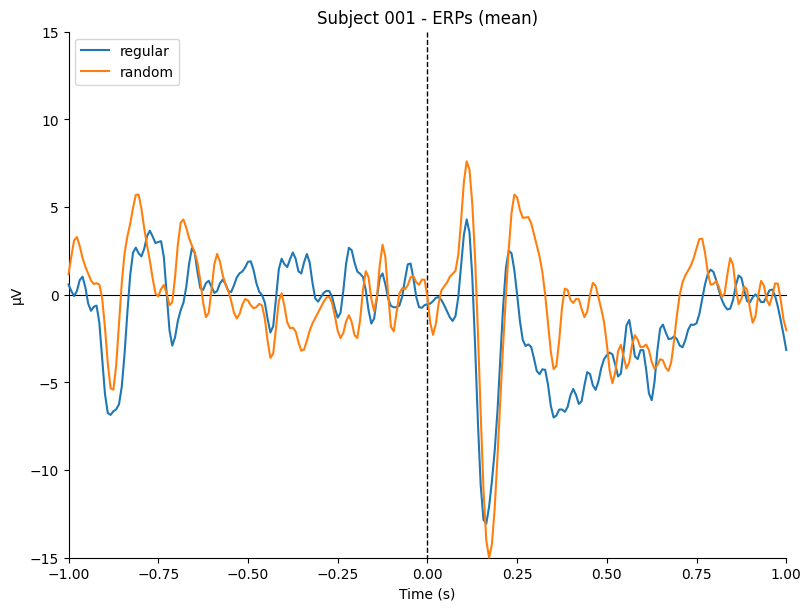

In [7]:
e1 = epochs['regular'].average()
e2 = epochs['random'].average()
evokeds = dict(regular = e1, random = e2)
picks = [f"PO{n}" for n in range(7, 9)]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean", title='Subject 001 - ERPs');
